# Bayes - A Nonparametric Bayesian Approach to Modeling Overlapping Clusters

In [2]:
%matplotlib inline

In [20]:
from matplotlib.pyplot import figure, show
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal 
from scipy.stats import beta

## Infinite Overlapping Mixture Model with Gaussian clusters

In [283]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)
df = pd.DataFrame(X, columns=['X1', 'X2'])
df['y']=y
df.head()

,X1,X2,y
0,-0.807236,2.669463,2
1,1.926358,4.152430,0
2,-1.500166,3.101333,2
3,-1.109050,2.877864,2
4,-2.531227,1.919691,2


In [284]:
#Initialiser le centre des clusters (Facultatif)
clr = KMeans(n_clusters=3)
clr.fit(X,y)
clr.score(X)
clr.cluster_centers_[1].reshape(2,1)

array([[ 0.94726224],
       [ 4.29657893]])

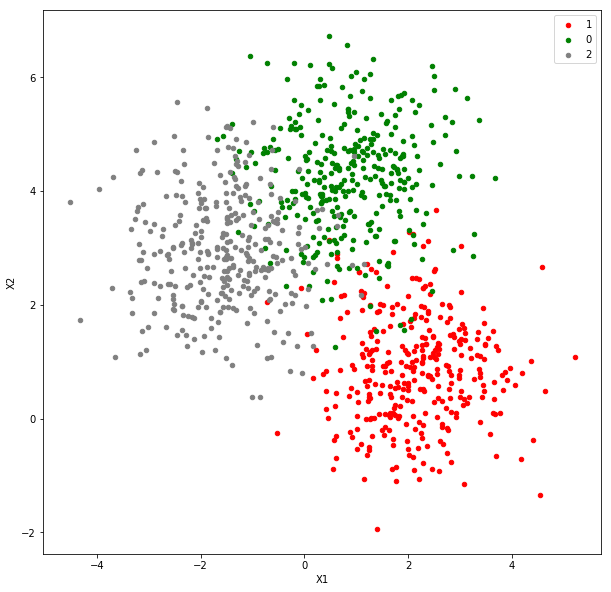

In [285]:
ax = df[y==1].plot(x="X1", y="X2", kind="scatter", label="1", color='r', figsize=(10,10))
df[y==0].plot(x="X1", y="X2", kind="scatter", label="0",color='green', ax=ax)
df[y==2].plot(x="X1", y="X2", kind="scatter", label="2",color='grey', ax=ax)

In [286]:
#Je recupere les "overlapping clusters" avec les kNearestNeighbor
#Si la probailité d'être dans le cluster k est d'au moins 0.1 (à tuner) alors l'observation appartient au cluster k
knn =  KNeighborsClassifier(n_neighbors=30)
knn.fit(X,y)
pred = knn.predict_proba(X)
pred

array([[ 0.06666667,  0.        ,  0.93333333],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.03333333,  0.        ,  0.96666667],
       ..., 
       [ 0.03333333,  0.86666667,  0.1       ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.06666667,  0.93333333,  0.        ]])

In [ ]:
#Load movie data



In [287]:
#Real clusters matrix
def possible_clusters(X):
    I=X.shape[0]
    J=X.shape[1]
    result = np.zeros(X.shape)
    for i in range(I):
        for j in range(J):
            if X[i,j]>0.1:
                result[i,j]=1
    return result
    
#Z = pd.get_dummies(y).as_matrix()
Z=possible_clusters(pred)
Z

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

In [306]:
#Create binary data to feed X
N=100
X=np.random.randint(2,size=N*2).reshape(N,2)

## Figure 3 algorithm
###  1. Initialize $\Theta$

In [144]:
#GAUSSIAN CLUSTERS
#mu=multivariate_normal.rvs(mean=np.zeros(2),cov=np.matrix([[1, 0], [0, 1]]),size=3)
#sigma=invwishart.rvs(df=4,size=3,scale=np.matrix([[1, 0], [0, 1]]))

In [307]:
#MULTIVARIATE BERNOULLI
#Initialize Theta matrix K=3 rows, D=2 columns
#D=2
#N=1000
#K=3 fixed for now
theta=np.empty([3,2])
for i in range(0,3):
    for j in range(0,2):
        u=np.random.uniform()
        theta[i,j]=u

In [308]:
theta

array([[ 0.0717987 ,  0.52338447],
       [ 0.28645854,  0.42242207],
       [ 0.47931619,  0.32524778]])

###  2. Initialize other elements

In [374]:
NumIters = 5
N = df.shape[0]
Z_hat = np.zeros((N,3)) #Matrix of clusters [observations]*[# clusters - takes 1 if belongs to cluster]
PZ_hat = np.zeros((N,3)) #Matrix of cluster probabilities
K=3

In [375]:
#On prend les n premieres observations et on leur donne les bons clusters associés pour entrainer le modele
n=100
for i in range(n):
    Z_hat[i,]=Z[i,]
Z_hat

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

###  3. Run algorithm

In [376]:
def m_without_i_k(Z, i, k):
    result=0
    for j in range(Z_hat.shape[0]):
        if j!=i:
            result+= Z_hat[j,k]
    return result

def likelihood_bern(X,Z,theta,i,k):  #not normalized
    temp=0
    lh=0
    for d in range(0,2):
        temp=temp+Z[i,k]*X[i,d]*np.log(theta[k,d]/(1-theta[k,d]))
    lh=np.exp(temp)
    return lh


for j in range(NumIters):
    for i in range(0,N):
        k_plus = [] #k+ is the number of clusters which data points, excluding i, belong to
        for k_ in range(K):
            if Z_hat[i,k_] == 0:
                k_plus.append(k_)  #for each obs, if proba to belong to cluster k_ is null, add it to k_plus
                                   #for data not in the training set, k_plus will take all possible values in 0...K
        print("Z initial:",Z[i,])
        print("k+=",k_plus)
        for k in k_plus:
            if Z_hat[i,k] == 0: #exclude data in the training set for which we already have the true categories
                #z_ik ⇠ zik|z−i,k, xi,theta
                theta_zi=np.zeros(6).reshape([3,2])
                Z_hat[i,k] = 1 #Set Z_hat to one (proposal)
                #Compute theta's of the Bernoulli likelihood function -- EQUATION (7) --
                for d in range(2):
                    num_temp=1
                    den_temp1=1
                    den_temp2=1
                    for k_ in range(K):
                        num_temp=num_temp*(theta[k_,d]**Z[i,k_])
                        den_temp1=den_temp1*((1-theta[k_,d])**Z[i,k_])
                        den_temp2=den_temp2*(theta[k_,d]**Z[i,k_])
                    theta_zi[:,d]=num_temp/(den_temp1+den_temp2)
                #compute bernouilli likelihood (not normalized)
                lh_bern=likelihood_bern(X,Z_hat,theta_zi,i,k)
                #compute matrix of probas of Z
                PZ_hat[i,k] = (m_without_i_k(Z_hat, i, k)/N)*lh_bern
                Z_hat[i,k] = 0  #reset Z_hat to zero
        #Propose adding new clusters 
        #Accept or reject proposal
        print("Proba Z:",PZ_hat[i,])
        print("Z_hat new:",Z_hat[i,])
        for k in k_plus:
            if Z_hat[i,k] == 0:
                u = np.random.uniform(0,1,1)  #PZ_hat is not normalized to [0,1]
                if u[0]<PZ_hat[i,k]:
                    Z_hat[i,k]=1
                    print(i,k)
        print("----------------")
    """
    #Resample theta|Z,X using MH proposal
    prob_A=0
    omega=0.5
    for k in range(K):
        for d in range(0,2):
            #generate proposal theta'(mu' and sigma') based on Beta(omega*theta,omega*(1-theta))
            T_prop=beta.rvs(omega*theta[k,d],omega*(1-theta[k,d]))
            T_mh=beta.rvs(omega*T_prop[k,d],omega*(1-T_prop[k,d]))
            #likelihood of x_d | ...
            lh_mh,lh_prop=np.zeros([2,3])
            for k_ in range(K):
                lh_mh[k_]=likelihood_bern(X,Z_hat,T_mh,i,k_)
                lh_prop[k_]=likelihood_bern(X,Z_hat,T_prop,i,k_)
            #priors beta
            xxx
    """

Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.02120912  0.01783494  0.        ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.00286204  0.00340351]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.01952409  0.01641798  0.        ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.01952409  0.01641798  0.        ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.044  0.037  0.   ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  1.  0.]
k+= [2]
Proba Z: [ 0.     0.     0.044]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.044  0.037  0.   ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.00286204  0.00340351]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0

Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01846717  0.01525549  0.01886863]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05051385  0.04172883  0.05161198]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.046  0.038  0.047]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05051385  0.04172883  0.05161198]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.046  0.038  0.047]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04234536  0.03498095  0.04326591]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02217317  0.01831697  0.0226552 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00390737  0.00322783  0.00399232]
Z_hat new: [ 0.  0.  0.]
----------------
Z init

----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04510702  0.0359015   0.04510702]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.049  0.039  0.049]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.049  0.039  0.049]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02361925  0.018799    0.02361925]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.049  0.039  0.049]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04510702  0.0359015   0.04510702]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02361925  0.018799    0.02361925]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0041622   0.00331277  0.0041622 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z in

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03583704  0.02925472  0.03729977]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02361925  0.01928102  0.0245833 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04510702  0.03682205  0.04694812]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04510702  0.03682205  0.04694812]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05380823  0.04392509  0.05600449]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.049  0.04   0.051]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00379027  0.0030941   0.00394498]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.049  0.04   0.051]
Z_hat 

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.01921737  0.01478259  0.01921737]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00129691  0.00099762  0.00129691]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00195997  0.00150767  0.00195997]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00402233  0.0030941   0.00402233]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00195997  0.00150767  0.00195997]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02013085  0.01548527  0.02013085]
Z_hat new: [ 0.  0.  0.]
446 0
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.053  0.04   0.052]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01556161  0.0117446

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02484884  0.01863663  0.02396138]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01644245  0.01233184  0.01585522]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.056  0.042  0.054]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.056  0.042  0.054]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.056  0.042  0.054]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04095661  0.03071746  0.03949388]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.007296    0.005472    0.00703543]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.056  0.042  0.054]
Z_hat new: [ 0.  0.  0.]
-----------

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.062  0.045  0.057]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.062  0.045  0.057]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04534482  0.03291156  0.04168798]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00154631  0.00112232  0.00142161]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.062  0.045  0.057]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01820414  0.01321269  0.01673607]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02751121  0.01996782  0.02529257]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00068614  0.00049801  0.00063081]
Z_hat new: [ 0.  0.  

k+= [0, 1, 2]
Proba Z: [ 0.068  0.049  0.061]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04973303  0.03583704  0.04461345]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00525997  0.00379027  0.0047185 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00484207  0.00348914  0.00434362]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.068  0.049  0.061]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00577612  0.0041622   0.00518152]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.068  0.049  0.061]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.06259749  0.04510702  0.05615363]
Z_hat new: [ 0.  0.  0.]
787 0
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
P

Proba Z: [ 0.07   0.053  0.066]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.06443859  0.04878922  0.06075639]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.07   0.053  0.066]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.07   0.053  0.066]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0768689   0.05820074  0.0724764 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0768689   0.05820074  0.0724764 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.07   0.053  0.066]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05119577  0.03876251  0.0482703 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.07   0.053  0.066]
Z_ha

k+= [1, 2]
Proba Z: [ 0.          0.0045638   0.00564673]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.05558398  0.          0.05338987]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [2]
Proba Z: [ 0.          0.          0.05862887]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.02231476  0.          0.02143391]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.076  0.059  0.   ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.076  0.059  0.   ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  1.]
k+= [1]
Proba Z: [ 0.     0.059  0.   ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  1.  1.]
k+= []
Proba Z: [ 0.  0.  0.]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.076  0.     0.073]
Z_hat new: [ 0.  1.  0.]
-----------

Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.079  0.06   0.076]
Z_hat new: [ 0.  0.  0.]
106 0
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08   0.06   0.076]
Z_hat new: [ 0.  0.  0.]
107 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08   0.06   0.077]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03211682  0.02408762  0.03091244]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08785018  0.06588763  0.08455579]
Z_hat new: [ 0.  0.  0.]
110 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08   0.06   0.078]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08785018  0.06588763  0.08565392]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.08   0.06   0.078]
Z_hat new: [ 0.  0.  0.]
113 1
----------------
Z initial: [ 0.  0.  1.]
k+

k+= [0, 1, 2]
Proba Z: [ 0.00640863  0.00469966  0.00583897]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.03326083  0.02439128  0.03030431]
Z_hat new: [ 0.  0.  0.]
197 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0665545   0.0482703   0.05997218]
Z_hat new: [ 0.  0.  0.]
198 1
198 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.091  0.067  0.083]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.091  0.067  0.083]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04037936  0.02972986  0.03682953]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.091  0.067  0.083]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00226959  0.00167102  0.00207006]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+=

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02877429  0.02084668  0.02613176]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00758055  0.00549203  0.00688437]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0083244   0.00603095  0.00755992]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.098  0.071  0.089]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.098  0.071  0.089]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00758055  0.00549203  0.00688437]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00304329  0.00220483  0.0027638 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0083244   0.00603095  0.00755992]
Z_hat 

k+= [0, 1, 2]
Proba Z: [ 0.00773525  0.00611085  0.00703908]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04437292  0.03505461  0.04037936]
Z_hat new: [ 0.  0.  0.]
414 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.1    0.079  0.092]
Z_hat new: [ 0.  0.  0.]
415 0
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00313645  0.00245326  0.00285696]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.0071919   0.00562535  0.00655104]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02965514  0.0231956   0.0270126 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.101  0.079  0.092]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.04868458  0.03808002  0.04434635]
Z_hat new: [ 0.  0.  0.]
420 1
----------------
Z initial: [ 

k+= [0, 1, 2]
Proba Z: [ 0.03053598  0.02554453  0.02818706]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.11420523  0.09553707  0.10542021]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.07606228  0.06362903  0.07021134]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08352606  0.06987276  0.07710098]
Z_hat new: [ 0.  0.  0.]
528 2
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.104  0.087  0.097]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04175187  0.03492704  0.03894165]
Z_hat new: [ 0.  0.  0.]
530 1
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.060397    0.09663519  0.10651834]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03053598  0.02583814  0.02848068]
Z_hat new: [ 0.  0.  0.]
532 0
----------------
Z

k+= [0, 1, 2]
Proba Z: [ 0.10310175  0.08837293  0.09205513]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04496355  0.03854019  0.04014603]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.112  0.043  0.1  ]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00866348  0.00742584  0.00773525]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.12299025  0.10542021  0.10981272]
Z_hat new: [ 0.  0.  0.]
642 0
642 1
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00959855  0.00823946  0.00849429]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00874083  0.00750319  0.00773525]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00959855  0.00823946  0.00849429]
Z_hat new: [ 0.  0.  0.]
645 2
----------------
Z

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.12   0.102  0.105]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.09637623  0.08191979  0.0843292 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.05324751  0.04526038  0.04659157]
Z_hat new: [ 0.  0.  0.]
748 1
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.12   0.103  0.105]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00132802  0.00113988  0.00116202]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0092823   0.00796731  0.00812201]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.04817523  0.01927009  0.04215333]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04817523  0.04135041  0.04215333]
Z_h

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.11783057  0.09849899  0.10310175]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.07577078  0.11749961  0.12299025]
Z_hat new: [ 1.  0.  0.]
855 1
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.128  0.108  0.064]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00482453  0.0040707   0.00422146]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.06169927  0.05205876  0.05398686]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00990112  0.00835407  0.00866348]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.06169927  0.05205876  0.05398686]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.10280131  0.0867386   0.0

Proba Z: [ 0.00954173  0.0081888   0.00826001]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.134  0.115  0.116]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05379568  0.04616793  0.04656939]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00416123  0.00357121  0.00360226]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.134  0.115  0.116]
Z_hat new: [ 0.  0.  0.]
969 1
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05379568  0.04656939  0.04656939]
Z_hat new: [ 0.  0.  0.]
970 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03934444  0.03405937  0.03435298]
Z_hat new: [ 0.  0.  0.]
971 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01036524  0.00897289  0.0091276 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+

Proba Z: [ 0.     0.122  0.122]
Z_hat new: [ 1.  0.  0.]
71 1
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.13506965  0.13397152]
Z_hat new: [ 1.  0.  0.]
72 2
----------------
Z initial: [ 1.  0.  1.]
k+= [1]
Proba Z: [ 0.     0.123  0.   ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.     0.123  0.123]
Z_hat new: [ 1.  0.  0.]
74 2
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.143  0.123  0.   ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  1.  0.]
k+= [2]
Proba Z: [ 0.     0.     0.124]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.13506965  0.13616777]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [1]
Proba Z: [ 0.     0.123  0.   ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.06892965  0.05928914  0.        ]
Z_hat new: [ 0.  0.  1.]
------------

----------------
Z initial: [ 1.  0.  0.]
k+= [0, 2]
Proba Z: [ 0.16911159  0.06918201  0.14495279]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.16911159  0.13836403  0.14495279]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.154  0.126  0.132]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.154  0.126  0.132]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.04326591  0.11598947  0.12151278]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01308121  0.0107028   0.01121246]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.11263069  0.09215238  0.09654059]
Z_hat new: [ 0.  0.  0.]
168 0
----------------
Z initial: [ 0.  1.  0.]
k+= [1, 2]
Proba Z: [ 0.03510567  0.09215238  0.09654059]
Z_hat new: [ 1.  0.  0.]
---------

Proba Z: [ 0.162  0.135  0.137]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00179283  0.00149402  0.00151616]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00610605  0.00508837  0.00516376]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.07808813  0.06507344  0.0660375 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01253111  0.01044259  0.01059729]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.06503656  0.05419714  0.05500006]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.162  0.069  0.137]
Z_hat new: [ 0.  1.  0.]
278 0
278 2
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.01160673  0.00961294  0.00982656]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [1, 2]


k+= [0, 1, 2]
Proba Z: [ 0.06985409  0.0566059   0.05740882]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00433965  0.00351661  0.0035665 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.098  0.141  0.143]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00655835  0.00531452  0.00538991]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05108905  0.04139975  0.04198698]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.174  0.141  0.143]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.06985409  0.0566059   0.05740882]
Z_hat new: [ 0.  0.  0.]
389 0
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.08435446  0.0679656   0.06892965]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+=

----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00685988  0.00546529  0.00569144]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 2]
Proba Z: [ 0.19985915  0.04502322  0.16581721]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.133109    0.10604838  0.11043658]
Z_hat new: [ 0.  0.  0.]
494 0
----------------
Z initial: [ 0.  1.  0.]
k+= [2]
Proba Z: [ 0.03876251  0.06216629  0.11043658]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.05373159  0.04257421  0.0443359 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02384228  0.01889142  0.01967314]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.183  0.145  0.151]
Z_hat new: [ 0.  0.  0.]
498 0
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.184  0.145  0.053]
Z_hat new: [ 0.  0.  1.]
------

Z_hat new: [ 0.  0.  0.]
599 1
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.14115404  0.11116795  0.07167407]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.193  0.152  0.161]
Z_hat new: [ 0.  0.  0.]
601 2
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.11859774  0.16691534  0.17789661]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.14115404  0.11116795  0.11848163]
Z_hat new: [ 0.  0.  0.]
603 0
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01647892  0.01291132  0.01376075]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0]
Proba Z: [ 0.17858696  0.08561128  0.09113458]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.09351295  0.07326788  0.07808813]
Z_hat new: [ 0.  0.  0.]
606 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01647892  0.0

Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.118  0.159  0.174]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.21   0.1    0.174]
Z_hat new: [ 0.  1.  0.]
702 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.211  0.159  0.174]
Z_hat new: [ 0.  0.  0.]
703 0
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.07834774  0.0587608   0.06430427]
Z_hat new: [ 0.  0.  0.]
704 0
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.00920495  0.01229905  0.01345934]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.06254005  0.04668482  0.05108905]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.00608898  0.0045453   0.0049741 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.06254005  0.04668482  0.05108905]
Z_hat new: [ 0.  0.  0.]
708 0
----------------
Z init

k+= [0, 1, 2]
Proba Z: [ 0.11962752  0.08733868  0.09951316]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.124  0.165  0.188]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.11962752  0.08733868  0.05716714]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.226  0.165  0.188]
Z_hat new: [ 0.  0.  0.]
809 0
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.227  0.165  0.109]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01755902  0.01276316  0.01454227]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.227  0.165  0.188]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.16602056  0.12067574  0.1374972 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01755902  0.

Proba Z: [ 0.071  0.174  0.194]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.07164212  0.05108905  0.05696136]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 2]
Proba Z: [ 0.26794304  0.05929887  0.21303668]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.26794304  0.19107413  0.21303668]
Z_hat new: [ 0.  0.  0.]
914 1
914 2
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.12915538  0.09263193  0.10321844]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.07164212  0.05138267  0.05725497]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.26794304  0.19217226  0.2141348 ]
Z_hat new: [ 0.  0.  0.]
917 0
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.11809625  0.08435446  0.09399498]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.

Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.0138461   0.01577991]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.          0.0138461   0.01577991]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [1]
Proba Z: [ 0.     0.179  0.   ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  1.]
k+= [1]
Proba Z: [ 0.          0.01274605  0.        ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  1.]
k+= []
Proba Z: [ 0.          0.06351904  0.        ]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.10397821  0.          0.0293066 ]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.07604635  0.          0.05989751]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.11492587  0.07942753  0.        ]
Z_hat new: [ 0.  0.  1.]
30 0
----------------
Z initial: [ 0.  0.  1.

Proba Z: [ 0.11847571  0.08164618  0.09185195]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.14132986  0.09739586  0.10957034]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02267975  0.01562949  0.01758318]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [1, 2]
Proba Z: [ 0.06585709  0.14777688  0.16624899]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= []
Proba Z: [ 0.1362416   0.11506892  0.04326591]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.267  0.184  0.207]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0]
Proba Z: [ 0.267  0.061  0.126]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1]
Proba Z: [ 0.046  0.184  0.078]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.16362095  0.20205541  0.22731233]

----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02142665  0.01508374  0.01717226]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [2]
Proba Z: [ 0.158  0.129  0.222]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.25499272  0.17950751  0.2043624 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.277  0.067  0.222]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.277  0.195  0.222]
Z_hat new: [ 0.  0.  0.]
232 1
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.11120449  0.07868621  0.08912418]
Z_hat new: [ 0.  0.  0.]
233 2
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.277  0.196  0.049]
Z_hat new: [ 0.  0.  1.]
234 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.11160595  0.07868621  0.08952564]
Z_hat new: [ 0.  0.  0.]
235 0
----------------
Z initi

327 1
----------------
Z initial: [ 1.  0.  0.]
k+= [2]
Proba Z: [ 0.167  0.071  0.235]
Z_hat new: [ 1.  1.  0.]
328 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.08632288  0.06048474  0.0692932 ]
Z_hat new: [ 0.  0.  0.]
329 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.21502222  0.0526585   0.17333424]
Z_hat new: [ 0.  1.  0.]
330 0
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.14219753  0.06651952  0.11424005]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.27156265  0.18963358  0.21817067]
Z_hat new: [ 0.  0.  0.]
332 0
332 1
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.2724832   0.12795664  0.21817067]
Z_hat new: [ 0.  1.  0.]
333 0
----------------
Z initial: [ 1.  0.  0.]
k+= [1]
Proba Z: [ 0.18448537  0.22731233  0.15373781]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.297  0.073  0.237]
Z_hat new: [ 

k+= [0, 1]
Proba Z: [ 0.16038557  0.11592225  0.04922726]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.14605373  0.10556359  0.12050638]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.01142057  0.00825447  0.00942291]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.14605373  0.10556359  0.12050638]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= []
Proba Z: [ 0.178  0.08   0.146]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.10681904  0.07720584  0.08813452]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.13444996  0.0971767   0.04171055]
Z_hat new: [ 0.  0.  1.]
436 1
----------------
Z initial: [ 0.  0.  1.]
k+= [0]
Proba Z: [ 0.27892706  0.12979774  0.04694812]
Z_hat new: [ 0.  1.  1.]
437 0
----------------
Z initial: [ 1.  1.  0.

Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.09013877  0.10990182  0.12725474]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.12806583  0.09153294  0.10598551]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.12806583  0.09153294  0.10598551]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1]
Proba Z: [ 0.319  0.228  0.154]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02467545  0.01763637  0.02042106]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02709678  0.01936698  0.02242492]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.12806583  0.09153294  0.10598551]
Z_hat new: [ 0.  0.  0.]
542 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02709678  0.01936698  0.02250987]
Z_hat new: [ 0.  0.  0.]
--------

k+= [0, 1, 2]
Proba Z: [ 0.332  0.242  0.282]
Z_hat new: [ 0.  0.  0.]
632 0
632 1
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02575839  0.01879666  0.02181341]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [1, 2]
Proba Z: [ 0.111  0.243  0.282]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.24354558  0.17772245  0.20624581]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.13368627  0.09755484  0.1132118 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.333  0.243  0.282]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0]
Proba Z: [ 0.3065436   0.14084436  0.15189097]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.13368627  0.09755484  0.1132118 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [2]
Proba Z: [

Proba Z: [ 0.343  0.256  0.3  ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.0085546   0.00638478  0.00748216]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.25085926  0.1170189   0.12725805]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02913541  0.02174538  0.02548287]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.343  0.256  0.3  ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.16533475  0.12339853  0.14460765]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0]
Proba Z: [ 0.37665763  0.17679848  0.19217226]
Z_hat new: [ 0.  1.  1.]
735 0
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.02449519  0.01822898  0.02136209]
Z_hat new: [ 0.  0.  0.]
736 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba 

----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03032461  0.02259481  0.02684196]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.14332132  0.10678843  0.12686144]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [2]
Proba Z: [ 0.06073521  0.07953421  0.15232006]
Z_hat new: [ 1.  1.  0.]
833 2
----------------
Z initial: [ 1.  0.  1.]
k+= []
Proba Z: [ 0.228  0.166  0.11 ]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.28671927  0.21363397  0.25459386]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.14332132  0.10678843  0.1272629 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02761485  0.02057577  0.02452075]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [2]
Proba Z: [ 0.09288375  0.12213847  0.23184369]
Z_hat new: [ 1.  1.  0.]
----

944 2
----------------
Z initial: [ 0.  1.  0.]
k+= []
Proba Z: [ 0.09996361  0.07065701  0.04616793]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.00925294  0.00688359  0.00828026]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [2]
Proba Z: [ 0.03917007  0.06034309  0.17573601]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.16462355  0.12246927  0.0865272 ]
Z_hat new: [ 0.  0.  1.]
948 1
----------------
Z initial: [ 1.  1.  0.]
k+= [1, 2]
Proba Z: [ 0.10601385  0.22246846  0.26664089]
Z_hat new: [ 1.  0.  0.]
949 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1]
Proba Z: [ 0.03151381  0.02352918  0.01664881]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0]
Proba Z: [ 0.371  0.177  0.068]
Z_hat new: [ 0.  1.  1.]
951 0
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.3424451   0.25499272  0.3065436 ]
Z_hat new: [ 0.  0. 

Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.15375928  0.          0.02970806]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.15375928  0.          0.01806571]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.383  0.283  0.   ]
Z_hat new: [ 0.  0.  1.]
57 0
57 1
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.35349172  0.26143658  0.        ]
Z_hat new: [ 0.  0.  1.]
58 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.28157672  0.          0.08849554]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.18557982  0.13689525  0.        ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.17083576  0.1260191   0.        ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= []
Proba Z: [ 0.262  0.121  0.   ]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+=

----------------
Z initial: [ 1.  0.  0.]
k+= [1]
Proba Z: [ 0.153  0.293  0.08 ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.07732631  0.26972155  0.32403407]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02985807  0.02266429  0.02722808]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.02985807  0.02266429  0.02722808]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [2]
Proba Z: [ 0.0227647   0.01588432  0.0298999 ]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.386  0.293  0.352]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [1, 2]
Proba Z: [ 0.085  0.293  0.352]
Z_hat new: [ 1.  0.  0.]
156 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.15496366  0.11762786  0.14171547]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0. 

k+= [0, 1, 2]
Proba Z: [ 0.21173013  0.1609149   0.19161577]
Z_hat new: [ 0.  0.  0.]
247 0
----------------
Z initial: [ 0.  1.  0.]
k+= []
Proba Z: [ 0.20551444  0.09507785  0.06143492]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [1]
Proba Z: [ 0.1132118   0.12204392  0.0899271 ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  1.  1.]
k+= [1, 2]
Proba Z: [ 0.094  0.304  0.362]
Z_hat new: [ 1.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.401  0.304  0.085]
Z_hat new: [ 0.  0.  1.]
251 0
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.19377426  0.09495903  0.17449324]
Z_hat new: [ 0.  1.  0.]
252 2
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.19377426  0.06314534  0.17497526]
Z_hat new: [ 0.  1.  0.]
253 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.11832694  0.08925903  0.10658233]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0,

k+= [0, 1, 2]
Proba Z: [ 0.01586818  0.01179749  0.01420975]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.421  0.313  0.377]
Z_hat new: [ 0.  0.  0.]
352 1
352 2
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.22284596  0.16620815  0.07463487]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.421  0.14   0.378]
Z_hat new: [ 0.  1.  0.]
354 2
----------------
Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.15833483  0.28905312  0.34888896]
Z_hat new: [ 1.  0.  0.]
355 2
----------------
Z initial: [ 1.  0.  0.]
k+= [1]
Proba Z: [ 0.18997601  0.34481194  0.15593406]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03256541  0.02428869  0.02939395]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03576096  0.02667207  0.0322783 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0

Proba Z: [ 0.19612832  0.14199336  0.17394186]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [1, 2]
Proba Z: [ 0.311  0.32   0.392]
Z_hat new: [ 1.  0.  0.]
462 2
----------------
Z initial: [ 1.  1.  1.]
k+= [2]
Proba Z: [ 0.18   0.222  0.393]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03754476  0.02718173  0.03338256]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.2339618   0.16938411  0.20802485]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03418981  0.0247528   0.03039954]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.442  0.32   0.393]
Z_hat new: [ 0.  0.  0.]
467 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.442  0.32   0.394]
Z_hat new: [ 0.  0.  0.]
468 2
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 2]
Proba Z: [ 0.48537222  0.24488

559 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.13447578  0.09777387  0.1195014 ]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [1]
Proba Z: [ 0.321  0.333  0.267]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 2]
Proba Z: [ 0.458  0.232  0.407]
Z_hat new: [ 0.  1.  0.]
562 2
----------------
Z initial: [ 1.  0.  0.]
k+= [1]
Proba Z: [ 0.19   0.333  0.268]
Z_hat new: [ 1.  0.  1.]
563 1
----------------
Z initial: [ 0.  1.  0.]
k+= [2]
Proba Z: [ 0.07679365  0.17040877  0.29839819]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.05967083  0.04351541  0.05315655]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.458  0.334  0.269]
Z_hat new: [ 0.  0.  1.]
566 0
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.13476939  0.09806749  0.11979502]
Z_hat new: [ 0.  0.  0.]
567 1
----------------
Z initial: [ 

----------------
Z initial: [ 1.  1.  0.]
k+= [2]
Proba Z: [ 0.00838002  0.00384084  0.01049996]
Z_hat new: [ 1.  1.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.34520575  0.25597884  0.20770854]
Z_hat new: [ 0.  0.  1.]
663 0
663 1
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.34593712  0.25671021  0.30790597]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0]
Proba Z: [ 0.51941417  0.17020972  0.18338724]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0]
Proba Z: [ 0.34593712  0.18064792  0.20843991]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.18989071  0.14091255  0.16901477]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 1]
Proba Z: [ 0.20988393  0.15574896  0.04526038]
Z_hat new: [ 0.  0.  1.]
668 0
----------------
Z initial: [ 1.  0.  0.]
k+= []
Proba Z: [ 0.1251865   0.27233555  0.1131071 ]
Z_hat new: [ 1

k+= [0]
Proba Z: [ 0.482  0.258  0.179]
Z_hat new: [ 0.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [1]
Proba Z: [ 0.12   0.368  0.18 ]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.03728391  0.02846572  0.03310687]
Z_hat new: [ 0.  0.  0.]
768 2
----------------
Z initial: [ 1.  1.  0.]
k+= [1]
Proba Z: [ 0.27868792  0.29555376  0.14536747]
Z_hat new: [ 1.  0.  1.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 2]
Proba Z: [ 0.482  0.103  0.429]
Z_hat new: [ 0.  1.  0.]
770 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.14152254  0.10805041  0.12625455]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  0.  1.]
k+= [2]
Proba Z: [ 0.11138671  0.14912932  0.39583708]
Z_hat new: [ 1.  1.  0.]
772 2
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.01496801  0.01142786  0.01338426]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 1.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.012

Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.06501255  0.04989941  0.05784683]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.146514    0.11245464  0.13036516]
Z_hat new: [ 0.  0.  0.]
----------------
Z initial: [ 0.  1.  0.]
k+= []
Proba Z: [ 0.129  0.051  0.189]
Z_hat new: [ 1.  1.  1.]
----------------
Z initial: [ 0.  0.  1.]
k+= [0, 2]
Proba Z: [ 0.24053073  0.02506533  0.21401933]
Z_hat new: [ 0.  1.  0.]
----------------
Z initial: [ 1.  0.  1.]
k+= [0, 1, 2]
Proba Z: [ 0.01880813  0.0144359   0.01673509]
Z_hat new: [ 0.  0.  0.]
875 2
----------------
Z initial: [ 0.  1.  0.]
k+= [0, 1]
Proba Z: [ 0.499  0.383  0.19 ]
Z_hat new: [ 0.  0.  1.]
----------------
Z initial: [ 0.  1.  0.]
k+= [1]
Proba Z: [ 0.17260287  0.28011399  0.04753893]
Z_hat new: [ 1.  0.  1.]
877 1
----------------
Z initial: [ 1.  0.  0.]
k+= [0, 1, 2]
Proba Z: [ 0.04238651  0.03261807  0.03779959]
Z_hat new: [ 

In [360]:
beta.rvs(omega*theta[k,],omega*(1-theta[k,]))

array([ 0.02684182,  0.09684184])

In [313]:
U = np.dot(Z,Z.T)
print(U)
U_hat = np.dot(Z_hat,Z_hat.T)
print(U_hat)

[[ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]]
[[ 2.  2.  2. ...,  2.  2.  2.]
 [ 2.  2.  2. ...,  2.  2.  2.]
 [ 2.  2.  2. ...,  2.  2.  2.]
 ..., 
 [ 2.  2.  2. ...,  2.  2.  2.]
 [ 2.  2.  2. ...,  2.  2.  2.]
 [ 2.  2.  2. ...,  2.  2.  2.]]


### 4. $U$ and $\hat{U}$ comparison

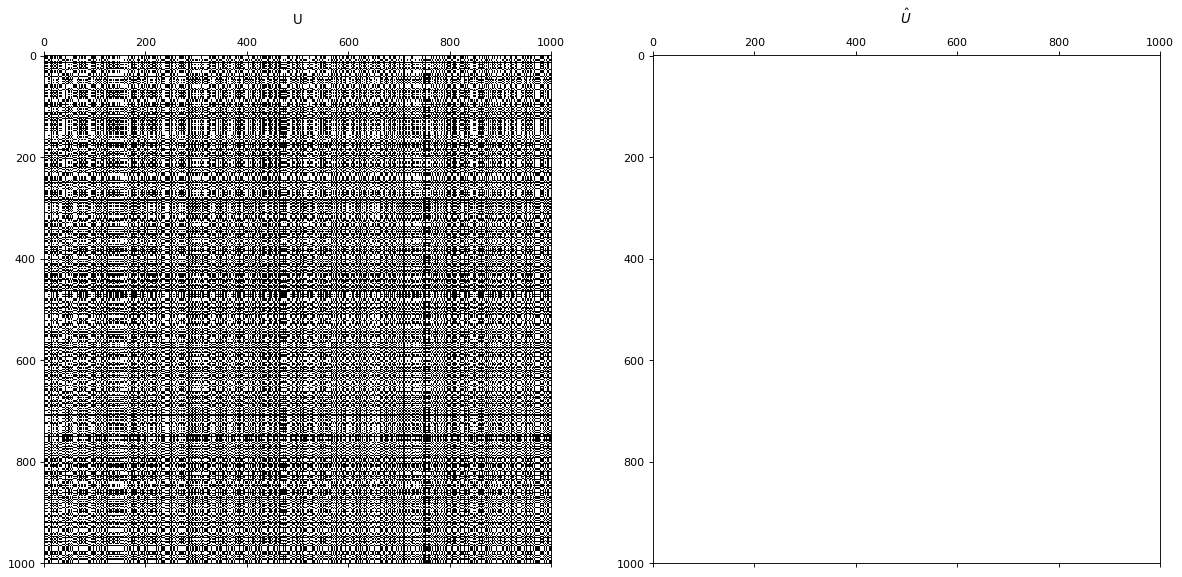

In [314]:
fig = figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('U')
ax2.title.set_text('$\hat{U}$')

ax1.spy(U)
ax2.spy(U_hat)

show()